In [1]:
!apt-get install -y libeigen3-dev
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install MedPy




Suggested packages:
  libeigen3-doc libmpfrc++-dev
The following NEW packages will be installed:
  libeigen3-dev
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 1056 kB of archives.
After this operation, 9081 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libeigen3-dev all 3.4.0-2ubuntu2 [1056 kB]
Fetched 1056 kB in 0s (3210 kB/s)
Selecting previously unselected package libeigen3-dev.
(Reading database ... 123110 files and directories currently installed.)
Preparing to unpack .../libeigen3-dev_3.4.0-2ubuntu2_all.deb ...
Unpacking libeigen3-dev (3.4.0-2ubuntu2) ...
Setting up libeigen3-dev (3.4.0-2ubuntu2) ...
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-34uc28ia
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-34uc28ia
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead

In [2]:
!pip install kaggle
!pip install pytorch-gradcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 44.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5249 sha256=b9fd4f888c1fd35852040f78f591d5576afc4351ee37a5d0cc1cb991c73fa996
  Stored in directory: /root/.cache/pip/wheels/6f/f1/8f/96c81d13f617841f23cae192a77fea3e9e988d058ba9414f2c
Successfully built pytorch-gradcam


In [3]:
!kaggle datasets download -d sabahesaraki/breast-ultrasound-images-dataset --unzip -p ./ 

print("下载完成!")

Dataset URL: https://www.kaggle.com/datasets/sabahesaraki/breast-ultrasound-images-dataset
License(s): unknown
 92%|█████████████████████████████████████▊   | 180M/195M [00:01<00:00, 205MB/s]
100%|█████████████████████████████████████████| 195M/195M [00:01<00:00, 151MB/s]
下载完成!


In [4]:
# Import necessary libraries
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import os
import random
from PIL import Image
import json
import torch.utils.data as data

In [5]:
root = os.path.join('Dataset_BUSI_with_GT')

# Loading

In [6]:
def make_dataset(root):
    classes = ['benign', 'malignant', 'normal']
    class_indices = dict((cls, idx) for idx, cls in enumerate(classes))

    # 将类别索引保存到 JSON 文件
    json_str = json.dumps(class_indices, indent=1)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    dataset = []
    for cls in classes:
        cls_index = class_indices[cls]
        cls_path = os.path.join(root, cls)

        # 检查目录是否存在
        if not os.path.exists(cls_path):
            print(f"Directory does not exist: {cls_path}")
            continue

        images = [img for img in os.listdir(cls_path) if not 'mask' in img]
        for img_name in images:
            img_path = os.path.join(cls_path, img_name)

            # 生成掩码文件路径
            mask_name = img_name.split('.')[0] + '_mask.png'
            mask_path = os.path.join(cls_path, mask_name)

            # 检查图像和掩码文件是否存在
            if not os.path.exists(img_path):
                print(f"Image file not found: {img_path}")
                continue
            if not os.path.exists(mask_path):
                print(f"Mask file not found: {mask_path}")
                continue

            dataset.append((img_path, mask_path, cls_index))

    return dataset

In [7]:
class ImageFolder(data.Dataset):
    def __init__(self, root, joint_transform=None, transform=None, target_transform=None):
        self.root  = root
        self.imgs = make_dataset(root)
        self.joint_transform = joint_transform
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        img_path, gt_path, label = self.imgs[index]
        img = Image.open(img_path).convert('RGB')
        target = Image.open(gt_path).convert('L')
        cla = label
        if self.joint_transform is not None:
            img, target, cla = self.joint_transform(img, target, cla)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, cla

    def __len__(self):
        return len(self.imgs)


class ImageFolder2(data.Dataset):
    def __init__(self, root, joint_transform=None, transform=None, target_transform=None):
        self.root  = root
        self.imgs = make_dataset(root)
        self.joint_transform = joint_transform
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        img_path, gt_path = self.imgs[index]
        img = Image.open(img_path).convert('RGB')
        target = Image.open(gt_path).convert('L')
        if self.joint_transform is not None:
            img, target = self.joint_transform(img, target)

        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.imgs)

# Pre-processing

In [8]:
import math
import numbers
import random

import torch
from PIL import Image, ImageOps
import numpy as np
import torchvision.transforms.functional as TF


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, mask):
        assert img.size == mask.size
        for t in self.transforms:
            img, mask = t(img, mask)
        return img, mask


class RandomCrop(object):
    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    def __call__(self, img, mask):
        if self.padding > 0:
            img = ImageOps.expand(img, border=self.padding, fill=0)
            mask = ImageOps.expand(mask, border=self.padding, fill=0)

        assert img.size == mask.size
        w, h = img.size
        th, tw = self.size
        if w == tw and h == th:
            return img, mask
        if w < tw or h < th:
            return img.resize((tw, th), Image.BILINEAR), mask.resize((tw, th), Image.NEAREST)

        x1 = random.randint(0, w - tw)
        y1 = random.randint(0, h - th)
        return img.crop((x1, y1, x1 + tw, y1 + th)), mask.crop((x1, y1, x1 + tw, y1 + th))


class CenterCrop(object):
    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, img, mask):
        assert img.size == mask.size
        w, h = img.size
        th, tw = self.size
        x1 = int(round((w - tw) / 2.))
        y1 = int(round((h - th) / 2.))
        return img.crop((x1, y1, x1 + tw, y1 + th)), mask.crop((x1, y1, x1 + tw, y1 + th))

class RandomHorizontallyFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, mask):

        if torch.rand(1) < self.p:
            return TF.hflip(img), TF.hflip(mask)
        return img, mask



class FreeScale(object):
    def __init__(self, size):
        self.size = tuple(reversed(size))  # size: (h, w)

    def __call__(self, img, mask):
        assert img.size == mask.size
        return img.resize(self.size, Image.BILINEAR), mask.resize(self.size, Image.NEAREST)


class Scale(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img, mask):
        assert img.size == mask.size
        w, h = img.size
        if (w >= h and w == self.size) or (h >= w and h == self.size):
            return img, mask
        if w > h:
            ow = self.size
            oh = int(self.size * h / w)
            return img.resize((ow, oh), Image.BILINEAR), mask.resize((ow, oh), Image.NEAREST)
        else:
            oh = self.size
            ow = int(self.size * w / h)
            return img.resize((ow, oh), Image.BILINEAR), mask.resize((ow, oh), Image.NEAREST)


class RandomSizedCrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img, mask):
        assert img.size == mask.size
        for attempt in range(10):
            area = img.size[0] * img.size[1]
            target_area = random.uniform(0.45, 1.0) * area
            aspect_ratio = random.uniform(0.5, 2)

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if random.random() < 0.5:
                w, h = h, w

            if w <= img.size[0] and h <= img.size[1]:
                x1 = random.randint(0, img.size[0] - w)
                y1 = random.randint(0, img.size[1] - h)

                img = img.crop((x1, y1, x1 + w, y1 + h))
                mask = mask.crop((x1, y1, x1 + w, y1 + h))
                assert (img.size == (w, h))

                return img.resize((self.size, self.size), Image.BILINEAR), mask.resize((self.size, self.size),
                                                                                       Image.NEAREST)

        # Fallback
        scale = Scale(self.size)
        crop = CenterCrop(self.size)
        return crop(*scale(img, mask))


class RandomRotate(object):
    def __init__(self, degree):
        self.degree = degree

    def __call__(self, img, mask):
        rotate_degree = random.random() * 2 * self.degree - self.degree
        return img.rotate(rotate_degree, Image.BILINEAR), mask.rotate(rotate_degree, Image.NEAREST)


class RandomSized(object):
    def __init__(self, size):
        self.size = size
        self.scale = Scale(self.size)
        self.crop = RandomCrop(self.size)

    def __call__(self, img, mask):
        assert img.size == mask.size

        w = int(random.uniform(0.5, 2) * img.size[0])
        h = int(random.uniform(0.5, 2) * img.size[1])

        img, mask = img.resize((w, h), Image.BILINEAR), mask.resize((w, h), Image.NEAREST)

        return self.crop(*self.scale(img, mask))


class SlidingCropOld(object):
    def __init__(self, crop_size, stride_rate, ignore_label):
        self.crop_size = crop_size
        self.stride_rate = stride_rate
        self.ignore_label = ignore_label

    def _pad(self, img, mask):
        h, w = img.shape[: 2]
        pad_h = max(self.crop_size - h, 0)
        pad_w = max(self.crop_size - w, 0)
        img = np.pad(img, ((0, pad_h), (0, pad_w), (0, 0)), 'constant')
        mask = np.pad(mask, ((0, pad_h), (0, pad_w)), 'constant', constant_values=self.ignore_label)
        return img, mask

    def __call__(self, img, mask):
        assert img.size == mask.size

        w, h = img.size
        long_size = max(h, w)

        img = np.array(img)
        mask = np.array(mask)

        if long_size > self.crop_size:
            stride = int(math.ceil(self.crop_size * self.stride_rate))
            h_step_num = int(math.ceil((h - self.crop_size) / float(stride))) + 1
            w_step_num = int(math.ceil((w - self.crop_size) / float(stride))) + 1
            img_sublist, mask_sublist = [], []
            for yy in range(h_step_num):
                for xx in range(w_step_num):
                    sy, sx = yy * stride, xx * stride
                    ey, ex = sy + self.crop_size, sx + self.crop_size
                    img_sub = img[sy: ey, sx: ex, :]
                    mask_sub = mask[sy: ey, sx: ex]
                    img_sub, mask_sub = self._pad(img_sub, mask_sub)
                    img_sublist.append(Image.fromarray(img_sub.astype(np.uint8)).convert('RGB'))
                    mask_sublist.append(Image.fromarray(mask_sub.astype(np.uint8)).convert('P'))
            return img_sublist, mask_sublist
        else:
            img, mask = self._pad(img, mask)
            img = Image.fromarray(img.astype(np.uint8)).convert('RGB')
            mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
            return img, mask


class SlidingCrop(object):
    def __init__(self, crop_size, stride_rate, ignore_label):
        self.crop_size = crop_size
        self.stride_rate = stride_rate
        self.ignore_label = ignore_label

    def _pad(self, img, mask):
        h, w = img.shape[: 2]
        pad_h = max(self.crop_size - h, 0)
        pad_w = max(self.crop_size - w, 0)
        img = np.pad(img, ((0, pad_h), (0, pad_w), (0, 0)), 'constant')
        mask = np.pad(mask, ((0, pad_h), (0, pad_w)), 'constant', constant_values=self.ignore_label)
        return img, mask, h, w

    def __call__(self, img, mask):
        assert img.size == mask.size

        w, h = img.size
        long_size = max(h, w)

        img = np.array(img)
        mask = np.array(mask)

        if long_size > self.crop_size:
            stride = int(math.ceil(self.crop_size * self.stride_rate))
            h_step_num = int(math.ceil((h - self.crop_size) / float(stride))) + 1
            w_step_num = int(math.ceil((w - self.crop_size) / float(stride))) + 1
            img_slices, mask_slices, slices_info = [], [], []
            for yy in range(h_step_num):
                for xx in range(w_step_num):
                    sy, sx = yy * stride, xx * stride
                    ey, ex = sy + self.crop_size, sx + self.crop_size
                    img_sub = img[sy: ey, sx: ex, :]
                    mask_sub = mask[sy: ey, sx: ex]
                    img_sub, mask_sub, sub_h, sub_w = self._pad(img_sub, mask_sub)
                    img_slices.append(Image.fromarray(img_sub.astype(np.uint8)).convert('RGB'))
                    mask_slices.append(Image.fromarray(mask_sub.astype(np.uint8)).convert('P'))
                    slices_info.append([sy, ey, sx, ex, sub_h, sub_w])
            return img_slices, mask_slices, slices_info
        else:
            img, mask, sub_h, sub_w = self._pad(img, mask)
            img = Image.fromarray(img.astype(np.uint8)).convert('RGB')
            mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
            return [img], [mask], [[0, sub_h, 0, sub_w, sub_h, sub_w]]

class Resize(object):

    def __init__(self, size):
        self.size = size

    def __call__(self, img, mask):

        img  = TF.resize(img, self.size, TF.InterpolationMode.BILINEAR)
        mask = TF.resize(mask, self.size, TF.InterpolationMode.NEAREST)

        return img, mask

class RandomVerticalFlip(object):
    def __init__(self, p=0.5):
        self.p = p


    def __call__(self, img, mask):
        if torch.rand(1) < self.p:
            return TF.vflip(img), TF.vflip(mask)
        return img, mask

# Loss functions

In [9]:
import numpy as np
import torch.nn as nn
import torch
import pydensecrf.densecrf as dcrf
from torch.optim import lr_scheduler
from medpy import metric

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input, target):
        N = target.size(0)
        smooth = 1e-6
        input = self.sigmoid(input)

        input_flat = input.view(N, -1)
        target_flat = target.view(N, -1)

        intersection = input_flat * target_flat

        loss = 2 * (intersection.sum(1) + smooth) / (input_flat.sum(1) + target_flat.sum(1) + smooth)
        loss = 1 - loss.sum() / N

        return loss


def dice_coef(output, target):
    smooth = 1e-6

    output = torch.sigmoid(output).view(-1).data.cpu().numpy()
    target = target.view(-1).data.cpu().numpy()
    intersection = (output * target).sum()

    return (2. * intersection + smooth) / \
           (output.sum() + target.sum() + smooth)

class AutomaticWeightedLoss(nn.Module):
    """automatically weighted multitask loss
    Params：
        num: int，the number of loss
        x: multitask loss
    Examples：
        loss1=1
        loss2=2
        awl = AutomaticWeightedLoss(2)
        loss_sum = awl(loss1, loss2)
    """
    def __init__(self, num=2):
        super(AutomaticWeightedLoss, self).__init__()
        params = torch.ones(num, requires_grad=True)
        self.params = torch.nn.Parameter(params)

    def forward(self, *x):
        loss_sum = 0
        for i, loss in enumerate(x):
            loss_sum += 0.5 / (self.params[i] ** 2) * loss + torch.log(1 + self.params[i] ** 2)
        return loss_sum


class AutoWeightedLoss(nn.Module):

    def __init__(self, num=2):
        super(AutoWeightedLoss, self).__init__()
        params = torch.ones(num, requires_grad=True)
        self.params = torch.nn.Parameter(params)

    def forward(self, *x):
        loss_sum = 0
        for i, loss in enumerate(x):
            loss_sum += (self.params[i]) * loss
        return loss_sum



class AutoLoss(nn.Module):

    def __init__(self, ):
        super(AutoLoss, self).__init__()
        params = torch.tensor(0.3, requires_grad=True)
        self.params = torch.nn.Parameter(params)

    def forward(self, x1, x2):
        loss_sum = self.params * x2 + (1-self.params) * x1
        return loss_sum


def metric_seg(pred,gt):
    pred = torch.sigmoid(pred)
    pre = np.array((pred>0.5).to(torch.int).detach().cpu())
    target = np.array(gt.to(torch.int).detach().cpu())

    di = metric.binary.dc(pre, target)
    ji = metric.binary.jc(pre, target)

    if pre.sum() > 0 and target.sum() > 0:
        hd95 = metric.binary.hd95(pre, target)
        asd = metric.binary.asd(pre, target)
        return di, ji, hd95, asd
    else:
        return di, ji, 0, 0


def metric_seg_1(pred,gt):
    pre = torch.sigmoid(pred)

    # 打印预测和目标的范围
#     print(f"Prediction range: {pre.min().item()} to {pre.max().item()}")
#     print(f"Target range: {gt.min().item()} to {gt.max().item()}")

    pre = np.array((pre>0.5).to(torch.int).detach().cpu())
    target = np.array(gt.to(torch.int).detach().cpu())

    # 检查维度是否一致
    if pre.shape != target.shape:
        print(f"Shape mismatch: Prediction shape: {pre.shape}, Target shape: {target.shape}")

    di = metric.binary.dc(pre, target)
    ji = metric.binary.jc(pre, target)
    return di, ji

def cmp_3(pred, gt):

    if pred.sum() > 0 and gt.sum() > 0:
        hd95 = metric.binary.hd95(pred, gt)
        asd = metric.binary.asd(pred, gt)
        return hd95, asd
    else:
        return 0, 0


def crf_refine(img, annos):
    assert img.dtype == np.uint8
    assert annos.dtype == np.uint8
    assert img.shape[:2] == annos.shape

    def _sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # img and annos should be np array with data type uint8

    EPSILON = 1e-8

    M = 2  # salient or not
    tau = 1.05
    # Setup the CRF model
    d = dcrf.DenseCRF2D(img.shape[1], img.shape[0], M)

    anno_norm = annos / 255.

    n_energy = -np.log((1.0 - anno_norm + EPSILON)) / (tau * _sigmoid(1 - anno_norm))
    p_energy = -np.log(anno_norm + EPSILON) / (tau * _sigmoid(anno_norm))

    U = np.zeros((M, img.shape[0] * img.shape[1]), dtype='float32')
    U[0, :] = n_energy.flatten()
    U[1, :] = p_energy.flatten()

    d.setUnaryEnergy(U)

    d.addPairwiseGaussian(sxy=3, compat=3)
    d.addPairwiseBilateral(sxy=60, srgb=5, rgbim=img, compat=5)

    # Do the inference
    infer = np.array(d.inference(1)).astype('float32')
    res = infer[1, :]

    res = res * 255
    res = res.reshape(img.shape[:2])
    return res.astype('uint8')



def create_lr_scheduler(optimizer,
                        num_step: int,
                        epochs: int,
                        warmup=True,
                        warmup_epochs=1,
                        warmup_factor=0.01):
    assert num_step > 0 and epochs > 0
    if warmup is False:
        warmup_epochs = 0

    def f(x):
        """
        根据step数返回一个学习率倍率因子，
        注意在训练开始之前，pytorch会提前调用一次lr_scheduler.step()方法
        """
        if warmup is True and x <= (warmup_epochs * num_step):
            alpha = float(x) / (warmup_epochs * num_step)
            # warmup过程中lr倍率因子从warmup_factor -> 1
            return warmup_factor * (1 - alpha) + alpha
        else:
            # warmup后lr倍率因子从1 -> 0
            # 参考deeplab_v2: Learning rate policy
            return (1 - (x - warmup_epochs * num_step) / ((epochs - warmup_epochs) * num_step)) ** 0.9

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=f)


def get_scheduler(optimizer, opt):
    """Return a learning rate scheduler
    Parameters:
        optimizer          -- the optimizer of the network
        opt (option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions．
                              opt.lr_policy is the name of learning rate policy: linear | step | plateau | cosine
    For 'linear', we keep the same learning rate for the first <opt.n_epochs> epochs
    and linearly decay the rate to zero over the next <opt.n_epochs_decay> epochs.
    For other schedulers (step, plateau, and cosine), we use the default PyTorch schedulers.
    See https://pytorch.org/docs/stable/optim.html for more details.
    """
    if opt == 'linear':
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + 1 - 90) / float(90 + 1)
            return lr_l
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif opt == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=opt.lr_decay_iters, gamma=0.1)
    elif opt == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    elif opt == 'cosine':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=opt.n_epochs, eta_min=0)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', opt.lr_policy)
    return scheduler


import torch.nn.functional as F
import torchvision


def structure_loss(pred, mask):
    weit  = 1+5*torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15)-mask)
    # wbce  = F.binary_cross_entropy_with_logits(pred, mask, reduction='none')
    wce  = F.cross_entropy(pred, mask)
    wce  = (weit*wce).sum(dim=(2,3))/weit.sum(dim=(2,3))

    # pred  = torch.sigmoid(pred)
    pred = torch.softmax(pred, dim=1)
    inter = ((pred*mask)*weit).sum(dim=(2,3))
    union = ((pred+mask)*weit).sum(dim=(2,3))
    wiou  = 1-(inter+1)/(union-inter+1)
    return (wce+wiou).mean()


#loss2u = LossNet(F.sigmoid(output), mask)

class LossNet(torch.nn.Module):
    def __init__(self, resize=True):
        super(LossNet, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl:
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1))
        self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1))
        self.resize = resize


    def forward(self, input, target):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(256, 256), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(256, 256), align_corners=False)
        loss = 0.0
        x = input
        y = target

        for block in self.blocks:
            x = block(x)
            y = block(y)
            loss += torch.nn.functional.mse_loss(x, y)
        return loss

In [10]:
import torch
from torch import nn


class DeformConv2d(nn.Module):
    def __init__(self, inc, outc, kernel_size=3, padding=1, stride=1, bias=None, modulation=False):
        """
        Args:
            modulation (bool, optional): If True, Modulated Defomable Convolution (Deformable ConvNets v2).
        """
        super(DeformConv2d, self).__init__()
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.zero_padding = nn.ZeroPad2d(padding)
        self.conv = nn.Conv2d(inc, outc, kernel_size=kernel_size, stride=kernel_size, bias=bias)

        self.p_conv = nn.Conv2d(inc, 2*kernel_size*kernel_size, kernel_size=3, padding=1, stride=stride)
        nn.init.constant_(self.p_conv.weight, 0)
        self.p_conv.register_full_backward_hook(self._set_lr)

        self.modulation = modulation
        if modulation:
            self.m_conv = nn.Conv2d(inc, kernel_size*kernel_size, kernel_size=3, padding=1, stride=stride)
            nn.init.constant_(self.m_conv.weight, 0)
            self.m_conv.register_full_backward_hook(self._set_lr)

    @staticmethod
    def _set_lr(module, grad_input, grad_output):
        grad_input = (grad_input[i] * 0.1 for i in range(len(grad_input)))
        grad_output = (grad_output[i] * 0.1 for i in range(len(grad_output)))

    def forward(self, x):
        offset = self.p_conv(x)
        if self.modulation:
            m = torch.sigmoid(self.m_conv(x))

        dtype = offset.data.type()
        ks = self.kernel_size
        N = offset.size(1) // 2

        if self.padding:
            x = self.zero_padding(x)

        # (b, 2N, h, w)
        p = self._get_p(offset, dtype)

        # (b, h, w, 2N)
        p = p.contiguous().permute(0, 2, 3, 1)
        q_lt = p.detach().floor()
        q_rb = q_lt + 1

        q_lt = torch.cat([torch.clamp(q_lt[..., :N], 0, x.size(2)-1), torch.clamp(q_lt[..., N:], 0, x.size(3)-1)], dim=-1).long()
        q_rb = torch.cat([torch.clamp(q_rb[..., :N], 0, x.size(2)-1), torch.clamp(q_rb[..., N:], 0, x.size(3)-1)], dim=-1).long()
        q_lb = torch.cat([q_lt[..., :N], q_rb[..., N:]], dim=-1)
        q_rt = torch.cat([q_rb[..., :N], q_lt[..., N:]], dim=-1)

        # clip p
        p = torch.cat([torch.clamp(p[..., :N], 0, x.size(2)-1), torch.clamp(p[..., N:], 0, x.size(3)-1)], dim=-1)

        # bilinear kernel (b, h, w, N)
        g_lt = (1 + (q_lt[..., :N].type_as(p) - p[..., :N])) * (1 + (q_lt[..., N:].type_as(p) - p[..., N:]))
        g_rb = (1 - (q_rb[..., :N].type_as(p) - p[..., :N])) * (1 - (q_rb[..., N:].type_as(p) - p[..., N:]))
        g_lb = (1 + (q_lb[..., :N].type_as(p) - p[..., :N])) * (1 - (q_lb[..., N:].type_as(p) - p[..., N:]))
        g_rt = (1 - (q_rt[..., :N].type_as(p) - p[..., :N])) * (1 + (q_rt[..., N:].type_as(p) - p[..., N:]))

        # (b, c, h, w, N)
        x_q_lt = self._get_x_q(x, q_lt, N)
        x_q_rb = self._get_x_q(x, q_rb, N)
        x_q_lb = self._get_x_q(x, q_lb, N)
        x_q_rt = self._get_x_q(x, q_rt, N)

        # (b, c, h, w, N)
        x_offset = g_lt.unsqueeze(dim=1) * x_q_lt + \
                   g_rb.unsqueeze(dim=1) * x_q_rb + \
                   g_lb.unsqueeze(dim=1) * x_q_lb + \
                   g_rt.unsqueeze(dim=1) * x_q_rt

        # modulation
        if self.modulation:
            m = m.contiguous().permute(0, 2, 3, 1)
            m = m.unsqueeze(dim=1)
            m = torch.cat([m for _ in range(x_offset.size(1))], dim=1)
            x_offset *= m

        x_offset = self._reshape_x_offset(x_offset, ks)
        out = self.conv(x_offset)

        return out

    def _get_p_n(self, N, dtype):
        p_n_x, p_n_y = torch.meshgrid(
            torch.arange(-(self.kernel_size-1)//2, (self.kernel_size-1)//2+1),
            torch.arange(-(self.kernel_size-1)//2, (self.kernel_size-1)//2+1))
        # (2N, 1)
        p_n = torch.cat([torch.flatten(p_n_x), torch.flatten(p_n_y)], 0)
        p_n = p_n.view(1, 2*N, 1, 1).type(dtype)

        return p_n

    def _get_p_0(self, h, w, N, dtype):
        p_0_x, p_0_y = torch.meshgrid(
            torch.arange(1, h*self.stride+1, self.stride),
            torch.arange(1, w*self.stride+1, self.stride))
        p_0_x = torch.flatten(p_0_x).view(1, 1, h, w).repeat(1, N, 1, 1)
        p_0_y = torch.flatten(p_0_y).view(1, 1, h, w).repeat(1, N, 1, 1)
        p_0 = torch.cat([p_0_x, p_0_y], 1).type(dtype)

        return p_0

    def _get_p(self, offset, dtype):
        N, h, w = offset.size(1)//2, offset.size(2), offset.size(3)

        # (1, 2N, 1, 1)
        p_n = self._get_p_n(N, dtype)
        # (1, 2N, h, w)
        p_0 = self._get_p_0(h, w, N, dtype)
        p = p_0 + p_n + offset
        return p

    def _get_x_q(self, x, q, N):
        b, h, w, _ = q.size()
        padded_w = x.size(3)
        c = x.size(1)
        # (b, c, h*w)
        x = x.contiguous().view(b, c, -1)

        # (b, h, w, N)
        index = q[..., :N]*padded_w + q[..., N:]  # offset_x*w + offset_y
        # (b, c, h*w*N)
        index = index.contiguous().unsqueeze(dim=1).expand(-1, c, -1, -1, -1).contiguous().view(b, c, -1)

        x_offset = x.gather(dim=-1, index=index).contiguous().view(b, c, h, w, N)

        return x_offset

    @staticmethod
    def _reshape_x_offset(x_offset, ks):
        b, c, h, w, N = x_offset.size()
        x_offset = torch.cat([x_offset[..., s:s+ks].contiguous().view(b, c, h, w*ks) for s in range(0, N, ks)], dim=-1)
        x_offset = x_offset.contiguous().view(b, c, h*ks, w*ks)

        return x_offset

# Model

In [11]:
pip install pretrainedmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 851.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=0bfdbce560dcf90dde537c2767775aa7b6748b12d8103a6a9b3f563ef2fa0456
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built pretrainedmodels
Note: you may need to restart the kernel to use updated packages.


In [12]:
import torch
import torch.nn as nn
# from torchvision.models.resnet import resnet18
from torchvision.models.resnet import resnet18, ResNet18_Weights
import torch.nn.functional as F


class CA_Module(nn.Module):
    def __init__(self, in_channel):
        super(CA_Module, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.maxpool = nn.AdaptiveMaxPool2d((1, 1))

        self.linear = nn.Sequential(nn.Linear(2 * in_channel, in_channel // 16),
                                    nn.ReLU(),
                                    nn.Linear(in_channel // 16, in_channel),
                                    nn.Sigmoid())

    def forward(self, x):
        b, c, _, _ = x.size()
        p1 = self.avgpool(x)
        p2 = self.maxpool(x)
        p = torch.flatten(torch.cat([p1, p2], dim=1), 1)
        po = self.linear(p).view(b, c, 1, 1)
        out = nn.ReLU()(x * po)
        return out


# class classifier_1(nn.Module):
#     def __init__(self):
#         super(classifier_1, self).__init__()
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)
#         # self.fc = nn.Sequential(nn.Linear(1280, 640), nn.ReLU(), nn.Linear(640, 2))
#         self.fc = nn.Sequential(nn.Linear(1280, 640), nn.ReLU(), nn.Linear(640, 3))
#         self.ca1 = CA_Module(256)
#         self.ca2 = CA_Module(512)
#         self.ca3 = CA_Module(512)
#         self.up = nn.UpsamplingBilinear2d(scale_factor=2)

#     def forward(self, input1, input2, input3):
#         c1 = self.ca1(input1)
#         c2 = self.up(self.ca2(input2))
#         c3 = self.ca3(input3)

#         all = self.avgpool(torch.cat([c1, c2, c3], 1))
#         c5 = torch.flatten(all, 1)
#         out = self.fc(c5)
#         return out


import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0

class TwoBranchClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(TwoBranchClassifier, self).__init__()

        # First branch (CA_Module)
        self.ca1 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.ca2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.ca3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.avgpool_branch1 = nn.AdaptiveAvgPool2d((1, 1))

        # Second branch (EfficientNet)
        self.efficientnet = efficientnet_b0(pretrained=True)
        self.efficientnet.classifier = nn.Identity()  # Remove final classification layer

        # Combine features and final classification
        self.fc = nn.Sequential(
            nn.Linear(1280 + 1280, 1024),  # 1280 from first branch, 1280 from EfficientNet
            nn.ReLU(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, input1, input2, input3, x):
        # First branch
        c1 = self.ca1(input1)
        c2 = self.up(self.ca2(input2))
        c3 = self.ca3(input3)
        branch1_features = self.avgpool_branch1(torch.cat([c1, c2, c3], 1))
        branch1_features = torch.flatten(branch1_features, 1)

        # Second branch (EfficientNet)
        branch2_features = self.efficientnet(x)
        branch2_features = torch.flatten(branch2_features, 1)

        # Combine features
        combined_features = torch.cat([branch1_features, branch2_features], dim=1)

        # Final classification
        out = self.fc(combined_features)
        return out


    
class GSA_Module(nn.Module):
    def __init__(self, in_channel):
        super(GSA_Module, self).__init__()

        self.output = nn.Sequential(nn.Conv2d(in_channel, in_channel, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(in_channel), nn.ReLU(inplace=True))

        self.gate = nn.Sequential(nn.Conv2d(in_channel, in_channel // 8, 3, 1),
                                  nn.BatchNorm2d(in_channel // 8), nn.ReLU(inplace=True),
                                  nn.Conv2d(in_channel // 8, 1, kernel_size=3, padding=1))

        self.sa = SpatialAttentionModule()

    def forward(self, x):
        b, c, _, _ = x.size()

        sal = self.sa(x)*x

        g1 = self.gate(x)
        g2 = F.adaptive_avg_pool2d(torch.sigmoid(g1), 1)
        g3 = self.output(g2.repeat(1, c, 1, 1) * sal)  #.unsqueeze(1)
        return g3


class SpatialAttentionModule(nn.Module):
    def __init__(self):
        super(SpatialAttentionModule, self).__init__()
        self.conv2d = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avgout = torch.mean(x, dim=1, keepdim=True)
        maxout, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avgout, maxout], dim=1)
        out = nn.ReLU(self.sigmoid(self.conv2d(out)) * x)
        return out


class GSA(nn.Module):
    def __init__(self, in_channel):
        super(GSA, self).__init__()

        self.output = nn.Sequential(nn.Conv2d(in_channel, in_channel, kernel_size=3, padding=1),
                                    nn.GroupNorm(in_channel // 4, in_channel), nn.ReLU())

        self.gate = nn.Sequential(nn.Conv2d(in_channel, in_channel // 8, kernel_size=3, padding=1),
                                  nn.GroupNorm(in_channel // 16, in_channel // 8), nn.ReLU(),
                                  nn.Conv2d(in_channel // 8, 2, kernel_size=3, padding=1))

    def forward(self, x):
        b, c, _, _ = x.size()
        g1 = self.gate(x)
        g2 = F.adaptive_avg_pool2d(torch.sigmoid(g1), 1)
        g3 = F.adaptive_max_pool2d(torch.sigmoid(g1), 1)
        output = self.output(g2[:, 0, :, :].unsqueeze(1).repeat(1, c, 1, 1) * x + \
                             g3[:, 1, :, :].unsqueeze(1).repeat(1, c, 1, 1) * x)

        return output


class DSAModule(nn.Module):
    def __init__(self, in_ch):
        super(DSAModule, self).__init__()

        self.dcn1 = nn.Sequential(DeformConv2d(in_ch, in_ch, 3, padding=1, modulation=True),
                                  nn.GroupNorm(in_ch // 4, in_ch), nn.ReLU())

        self.dcn2 = nn.Sequential(DeformConv2d(2 * in_ch, in_ch, 3, padding=1, modulation=True),
                                  nn.GroupNorm(in_ch // 4, in_ch), nn.ReLU())

        self.conv1 = nn.Sequential(nn.Conv2d(1, 1, 3, 1, 1), nn.Sigmoid())
        self.conv2 = nn.Sequential(nn.Conv2d(1, 1, 3, 1, 1), nn.Sigmoid())

    def forward(self, x):
        c1 = self.dcn1(x)
        # torch.mean(x,1).unsqueeze(1)
        avgout = self.conv1(torch.mean(c1, 1).unsqueeze(1))
        o1 = avgout * c1
        # torch.max(x, dim=1, keepdim=True)
        maxout = self.conv2(torch.max(c1, 1)[0].unsqueeze(1))
        o2 = maxout * c1

        out = torch.cat([o1, o2], dim=1)
        out = self.dcn2(out)
        return out



class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
#         self.base_model = resnet18(pretrained=True)
        self.base_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.base_layers = list(self.base_model.children())
        self.layer0 = nn.Sequential(*self.base_layers[:3])  # 64*128*128
        self.layer1 = nn.Sequential(*self.base_layers[3:5])  # 64*64*64
        self.layer2 = self.base_layers[5]  # 128  *32*32
        self.layer3 = self.base_layers[6]  # 256 *16*16
        self.layer4 = self.base_layers[7]  # 512 *8*8

        self.conv2 = nn.Sequential(nn.Conv2d(512, 512, 3, 1, 1), nn.GroupNorm(16, 512),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(512, 512, 3, 1, 1), nn.GroupNorm(16, 512),
                                   nn.ReLU(inplace=True))

        self.conv3 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.GroupNorm(8, 256),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(256, 256, 3, 1, 1), nn.GroupNorm(8, 256),
                                   nn.ReLU(inplace=True))

        self.conv4 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1), nn.GroupNorm(4, 128),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(128, 128, 3, 1, 1), nn.GroupNorm(4, 128),
                                   nn.ReLU(inplace=True))

        self.conv5 = nn.Sequential(nn.Conv2d(128, 128, 1), nn.ReLU(inplace=True),
                                   nn.Conv2d(128, 128, 3, 1, 1), nn.GroupNorm(4, 128),
                                   nn.ReLU(inplace=True))

        self.up1 = nn.Sequential(nn.Conv2d(512, 256, 1), nn.ReLU(inplace=True),
                                 nn.UpsamplingBilinear2d(scale_factor=2))

        self.up2 = nn.Sequential(nn.Conv2d(512, 128, 1), nn.ReLU(inplace=True),
                                 nn.UpsamplingBilinear2d(scale_factor=2))

        self.up3 = nn.Sequential(nn.Conv2d(256, 64, 1), nn.ReLU(inplace=True),
                                 nn.UpsamplingBilinear2d(scale_factor=2))

        self.up4 = nn.Sequential(nn.Conv2d(128, 64, 1), nn.ReLU(inplace=True),
                                 nn.UpsamplingBilinear2d(scale_factor=2))

        self.out = nn.Sequential(nn.UpsamplingBilinear2d(scale_factor=2),
                                 nn.Conv2d(128, 128, 3, 1, 1), nn.GroupNorm(4, 128),
                                 nn.ReLU(inplace=True),
                                 nn.Conv2d(128, 1, 1))

#         self.classfer = classifier_1()
        self.classfier = TwoBranchClassifier()

        self.g1 = GSA(512)
        self.g2 = GSA(256)
        self.g3 = GSA(128)
        self.g4 = GSA(64)
        self.g5 = GSA(64)

        self.sa1 = DSAModule(512)
        self.sa2 = DSAModule(256)


    def forward(self, x):
        layer0 = self.layer0(x)  # 64
        layer1 = self.layer1(layer0)  # 64
        layer2 = self.layer2(layer1)  # 128
        layer3 = self.layer3(layer2)  # 256
        layer4 = self.layer4(layer3)  # 512

        up1 = self.up1(self.g1(layer4))
        ffm1 = torch.cat([self.g2(layer3), up1], dim=1)
        ffm1 = self.sa1(self.conv2(ffm1))

        classfier = self.classfier(layer3, layer4, ffm1, x)

        up2 = self.up2(ffm1)
        ffm2 = torch.cat([self.g3(layer2), up2], dim=1)
        ffm2 = self.sa2(self.conv3(ffm2))

        up3 = self.up3(ffm2)
        ffm3 = torch.cat([self.g4(layer1), up3], dim=1)
        ffm3 = self.conv4(ffm3)

        up4 = self.up4(ffm3)
        ffm4 = torch.cat([self.g5(layer0), up4], dim=1)
        out = self.conv5(ffm4)
        out = self.out(out)

        return classfier, out


In [13]:
    from torch.autograd import Variable
    x = Variable(torch.rand(2, 3, 256, 256))
    model = MyModel()
    c, s = model(x)
    print('Output s shape:', s.shape)
    print('Output c shape:', c.shape)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████

Output s shape: torch.Size([2, 1, 256, 256])
Output c shape: torch.Size([2, 3])


# Train

In [14]:
class JointCompose:
    def __init__(self, transforms=None):
        self.transforms = transforms

    def __call__(self, img, mask, label):
        for t in self.transforms:
            img, mask = t(img, mask)
        return img, mask, label

In [15]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0.0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.epochs_no_improve = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
    
    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                if self.verbose:
                    print("Early stopping")
                self.early_stop = True
        else:
            self.best_score = score
            self.epochs_no_improve = 0
            self.save_checkpoint(val_loss, model, path)

    def save_checkpoint(self, val_loss, model, path):
        """
        Saves the model when the validation loss decreases.
        """
        if val_loss < self.val_loss_min:
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
            torch.save(model.state_dict(), path)
            self.val_loss_min = val_loss

# With Early stopping

Mask file not found: Dataset_BUSI_with_GT/benign/benign (25)_mask_1_mask.png
Mask file not found: Dataset_BUSI_with_GT/benign/benign (195)_mask_1_mask.png
Mask file not found: Dataset_BUSI_with_GT/benign/benign (54)_mask_1_mask.png
Mask file not found: Dataset_BUSI_with_GT/benign/benign (100)_mask_1_mask.png
Mask file not found: Dataset_BUSI_with_GT/benign/benign (98)_mask_1_mask.png
Mask file not found: Dataset_BUSI_with_GT/benign/benign (424)_mask_1_mask.png
Mask file not found: Dataset_BUSI_with_GT/benign/benign (163)_mask_1_mask.png
Mask file not found: Dataset_BUSI_with_GT/benign/benign (195)_mask_2_mask.png
Mask file not found: Dataset_BUSI_with_GT/benign/benign (181)_mask_1_mask.png
Mask file not found: Dataset_BUSI_with_GT/benign/benign (173)_mask_1_mask.png
Mask file not found: Dataset_BUSI_with_GT/benign/benign (315)_mask_1_mask.png
Mask file not found: Dataset_BUSI_with_GT/benign/benign (83)_mask_1_mask.png
Mask file not found: Dataset_BUSI_with_GT/benign/benign (93)_mask_1_

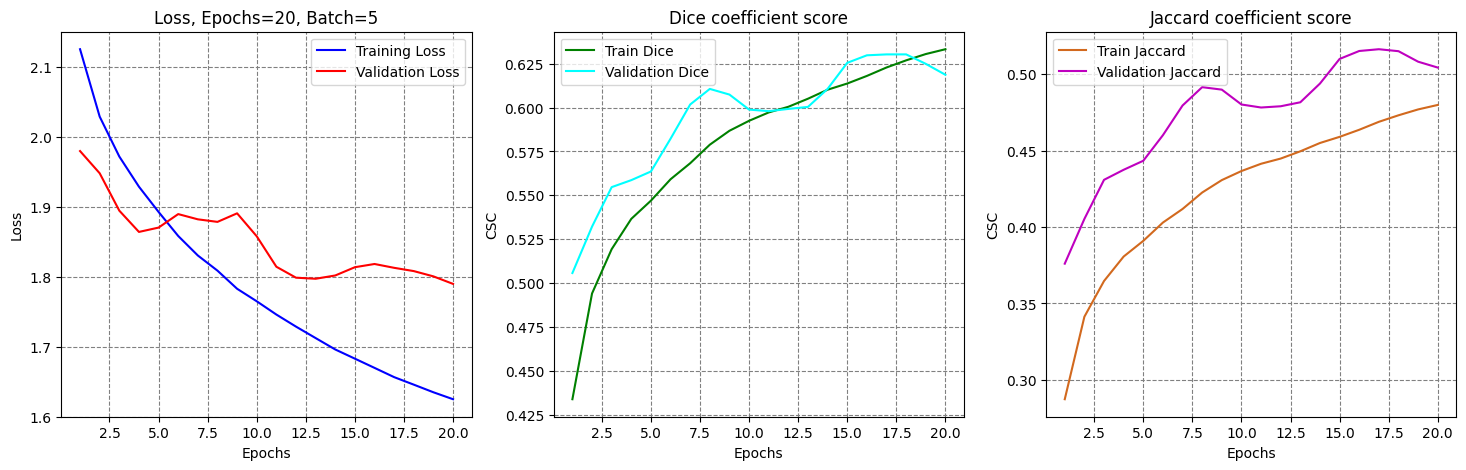


Cross validation fold 2
Epoch:1| TrainLoss:1.6889 ValidLoss:1.6495| Acc:94.87% Pre:95.23% Recall:96.33% F1:94.93%|Dice:62.40% JA:49.60% HD95:36.29 ASD:9.91.
Validation loss decreased (inf --> 1.649495). Saving model...
Epoch:2| TrainLoss:1.6824 ValidLoss:1.7444| Acc:82.69% Pre:87.04% Recall:85.66% F1:83.16%|Dice:63.10% JA:51.20% HD95:38.35 ASD:12.60.
Epoch:3| TrainLoss:1.6662 ValidLoss:1.6186| Acc:96.15% Pre:96.43% Recall:97.47% F1:96.20%|Dice:64.10% JA:52.30% HD95:34.47 ASD:10.61.
Validation loss decreased (1.649495 --> 1.618626). Saving model...
Epoch:4| TrainLoss:1.6510 ValidLoss:1.6487| Acc:94.87% Pre:95.07% Recall:95.88% F1:94.90%|Dice:59.10% JA:46.90% HD95:46.52 ASD:17.00.
Epoch:5| TrainLoss:1.6422 ValidLoss:1.6087| Acc:96.79% Pre:97.05% Recall:97.82% F1:96.84%|Dice:65.50% JA:53.60% HD95:37.45 ASD:12.70.
Validation loss decreased (1.618626 --> 1.608695). Saving model...
Epoch:6| TrainLoss:1.6351 ValidLoss:1.6327| Acc:93.59% Pre:94.16% Recall:95.19% F1:93.69%|Dice:62.60% JA:51.10

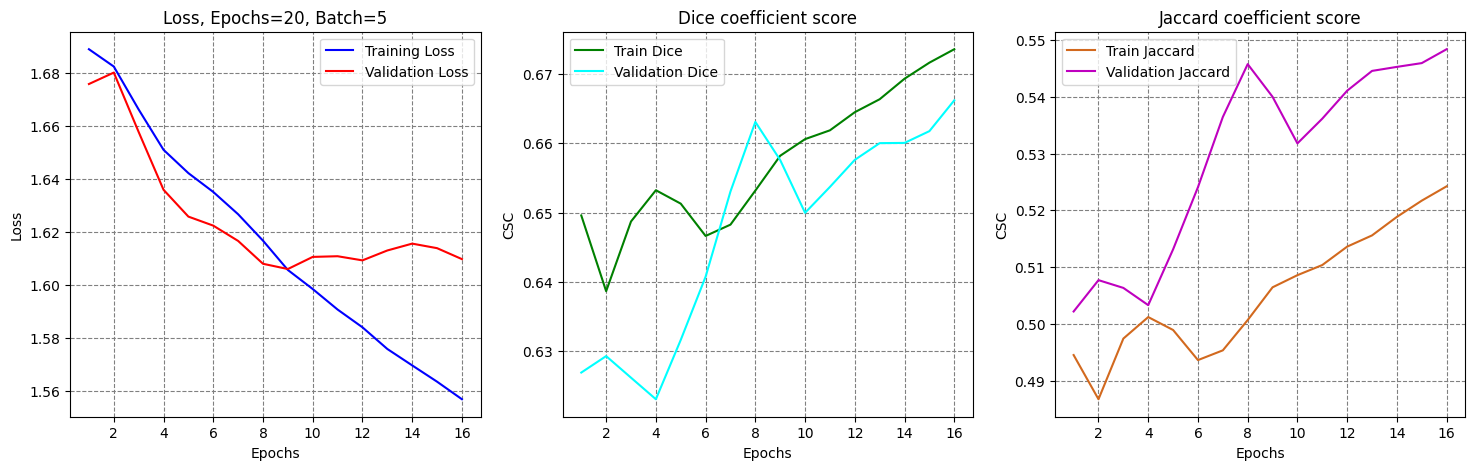


Cross validation fold 3
Epoch:1| TrainLoss:1.6482 ValidLoss:1.6319| Acc:92.31% Pre:94.15% Recall:94.72% F1:92.60%|Dice:66.80% JA:56.30% HD95:35.77 ASD:11.57.
Validation loss decreased (inf --> 1.631858). Saving model...
Epoch:2| TrainLoss:1.6336 ValidLoss:1.5825| Acc:97.44% Pre:97.47% Recall:97.07% F1:97.44%|Dice:68.90% JA:58.10% HD95:32.37 ASD:11.43.
Validation loss decreased (1.631858 --> 1.582531). Saving model...
Epoch:3| TrainLoss:1.6272 ValidLoss:1.5726| Acc:98.08% Pre:98.13% Recall:97.95% F1:98.08%|Dice:68.80% JA:57.80% HD95:34.57 ASD:11.53.
Validation loss decreased (1.582531 --> 1.572643). Saving model...
Epoch:4| TrainLoss:1.6169 ValidLoss:1.5686| Acc:98.08% Pre:98.09% Recall:97.95% F1:98.08%|Dice:64.20% JA:54.00% HD95:36.90 ASD:13.66.
Validation loss decreased (1.572643 --> 1.568610). Saving model...
Epoch:5| TrainLoss:1.6087 ValidLoss:1.6104| Acc:95.51% Pre:95.85% Recall:96.52% F1:95.55%|Dice:60.90% JA:49.70% HD95:44.20 ASD:16.18.
Epoch:6| TrainLoss:1.6072 ValidLoss:1.5851

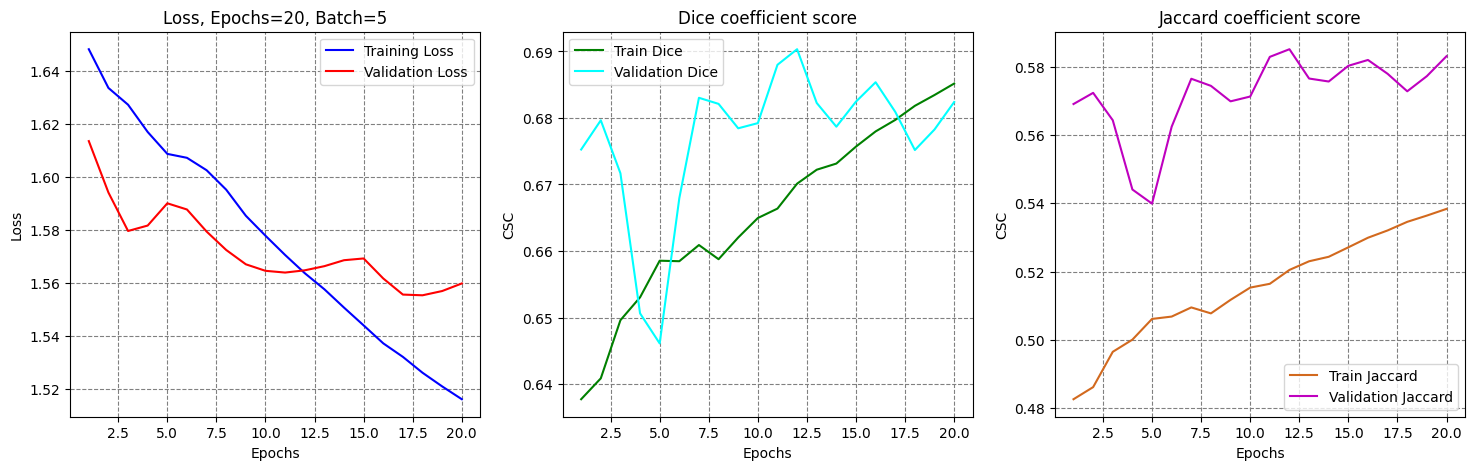


Cross validation fold 4
Epoch:1| TrainLoss:1.5723 ValidLoss:1.6363| Acc:96.79% Pre:97.03% Recall:97.89% F1:96.80%|Dice:62.90% JA:50.60% HD95:36.73 ASD:12.14.
Validation loss decreased (inf --> 1.636300). Saving model...
Epoch:2| TrainLoss:1.5810 ValidLoss:1.7929| Acc:90.38% Pre:92.09% Recall:93.32% F1:90.51%|Dice:61.20% JA:50.60% HD95:38.73 ASD:14.12.
Epoch:3| TrainLoss:1.5765 ValidLoss:1.6457| Acc:95.51% Pre:95.76% Recall:96.69% F1:95.53%|Dice:63.70% JA:52.30% HD95:30.40 ASD:10.33.
Epoch:4| TrainLoss:1.5781 ValidLoss:1.6309| Acc:95.51% Pre:95.71% Recall:96.69% F1:95.51%|Dice:65.40% JA:53.70% HD95:29.74 ASD:9.21.
Validation loss decreased (1.636300 --> 1.630928). Saving model...
Epoch:5| TrainLoss:1.5710 ValidLoss:1.6367| Acc:95.51% Pre:96.00% Recall:97.05% F1:95.54%|Dice:65.60% JA:54.60% HD95:36.06 ASD:14.21.
Epoch:6| TrainLoss:1.5640 ValidLoss:1.6618| Acc:95.51% Pre:95.71% Recall:96.69% F1:95.51%|Dice:60.60% JA:49.50% HD95:34.90 ASD:11.65.
Epoch:7| TrainLoss:1.5558 ValidLoss:1.6576|

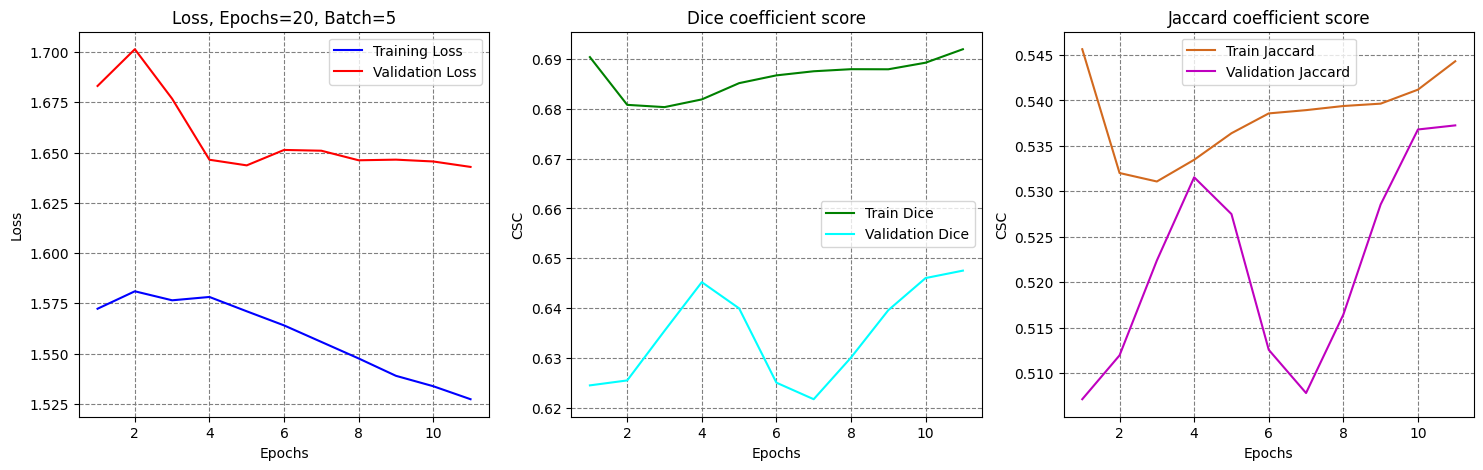


Cross validation fold 5
Epoch:1| TrainLoss:1.5937 ValidLoss:1.5875| Acc:97.44% Pre:97.50% Recall:98.07% F1:97.45%|Dice:67.90% JA:56.50% HD95:24.08 ASD:5.42.
Validation loss decreased (inf --> 1.587529). Saving model...
Epoch:2| TrainLoss:1.5793 ValidLoss:1.5910| Acc:96.15% Pre:96.39% Recall:97.28% F1:96.19%|Dice:65.10% JA:54.90% HD95:32.46 ASD:11.92.
Epoch:3| TrainLoss:1.5778 ValidLoss:1.6209| Acc:96.79% Pre:96.94% Recall:96.83% F1:96.83%|Dice:61.10% JA:49.80% HD95:45.77 ASD:17.49.
Epoch:4| TrainLoss:1.5698 ValidLoss:1.5908| Acc:97.44% Pre:97.55% Recall:96.49% F1:97.43%|Dice:64.40% JA:53.60% HD95:37.73 ASD:14.27.
Epoch:5| TrainLoss:1.5714 ValidLoss:1.5991| Acc:97.44% Pre:97.50% Recall:98.07% F1:97.45%|Dice:68.80% JA:58.00% HD95:28.45 ASD:8.43.
Epoch:6| TrainLoss:1.5690 ValidLoss:1.6239| Acc:92.95% Pre:93.96% Recall:95.32% F1:93.08%|Dice:67.10% JA:56.10% HD95:32.59 ASD:9.27.
Epoch:7| TrainLoss:1.5618 ValidLoss:1.6147| Acc:98.72% Pre:98.72% Recall:98.85% F1:98.72%|Dice:61.70% JA:50.80% 

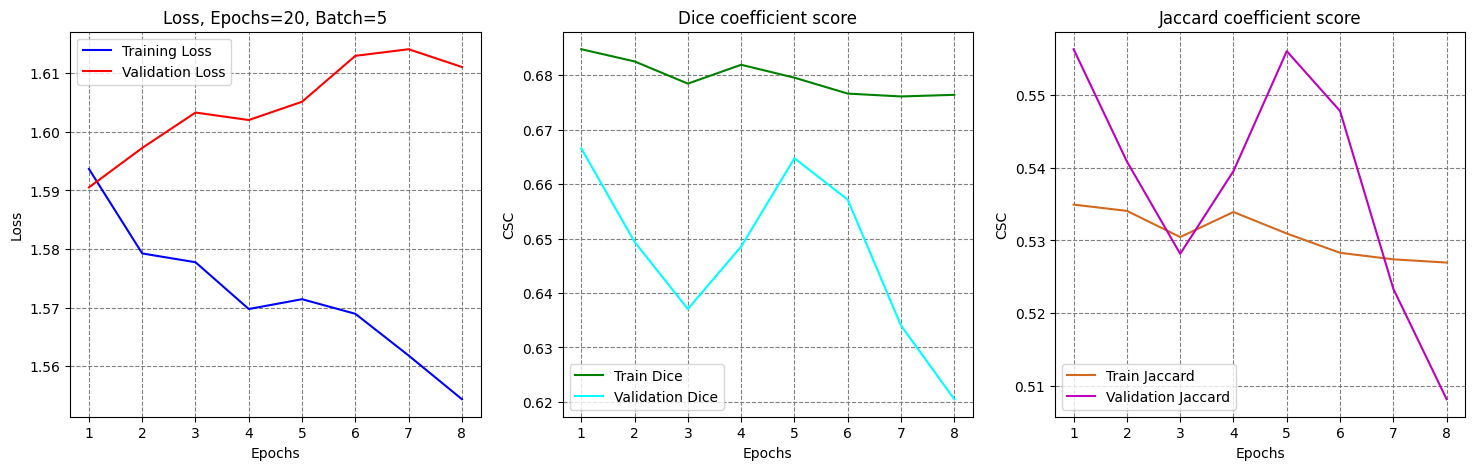


 ########## 最终5折交叉验证结果 ##########
Average Train Loss:1.5559
Average Val Loss:1.6393

 ########## Segmentation Results ##########
Average Test Jaccard:62.04%±0.03224 
Average Test Dice:68.22%±0.03022
Average Test HD95:15.01±2.921
Average Test ASD:4.57±1.287

 ########## Classification Results ##########
Average Test Accuracy:95.26%±0.04146
Average Test Precision:95.52%±0.03981
Average Test Recall:95.79%±0.04731
Average Test F1 Score:95.28%±0.04128


In [16]:
import math
import os
import random
import numpy as np
import torch
from sklearn.model_selection import KFold
from torch import optim
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader,SubsetRandomSampler

import torch.nn as nn
import torch.backends.cudnn as cudnn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Check if result directories exist, if not, create them
def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

train_path = root

joint_transforms= JointCompose([
    Resize((256,256)),
    RandomHorizontallyFlip(0.6),
    RandomRotate(30),
    RandomVerticalFlip(0.6)
    ])

val_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.330, 0.330, 0.330], [0.204, 0.204, 0.204])
])

# ,
#     transforms.Normalize([0.248, 0.248, 0.248], [0.151, 0.151, 0.151])

transform = transforms.Compose([
    transforms.ToTensor(),
     transforms.Normalize([0.330, 0.330, 0.330], [0.204, 0.204, 0.204])
])

# ,
#     transforms.Normalize([0.248, 0.248, 0.248], [0.151, 0.151, 0.151])

#transforms.Normalize([0.330, 0.330, 0.330], [0.204, 0.204, 0.204])

target_transform = transforms.ToTensor()
val_target_transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])  #transforms.Resize((256,256)),



def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = MyModel()
    net = net.to(device)

    # Ensure necessary directories exist
    ensure_dir('./Result/pth/')
    ensure_dir('./Result/TestResult/')
    ensure_dir('./Result/pic/')

    train_set = ImageFolder(train_path, joint_transforms, transform, target_transform)
    test_set = ImageFolder(train_path, None, val_transform, val_target_transform)

    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    fold = 1

    num_epochs = 100

    tr_loss = []
    val_loss = []
    test_hd95 = []
    test_asd = []
    test_ji = []
    test_dice = []
    test_acc = []
    test_pre = []
    test_recall = []
    test_f1 = []

    for train_idx,test_idx in cv.split(train_set):

        print("\nCross validation fold %d" % fold)

        train_sampler = SubsetRandomSampler(train_idx)
        test_sampler = SubsetRandomSampler(test_idx)

        train_loader = DataLoader(train_set, batch_size=8,
                              num_workers=1, shuffle=False, sampler=train_sampler)

        val_loader = DataLoader(test_set, batch_size=2,
                                  num_workers=1, shuffle=False, sampler=test_sampler)

        test_loader = DataLoader(test_set, batch_size=1, num_workers=1,
                             shuffle=False, sampler=test_sampler)



        train_loss, avg_val_loss, pre_ji, pre_dice, \
            hd95, asd, pre_class_acc, pre, recall, f1 = train(net, train_loader, val_loader, test_loader, fold, num_epochs, device)

        tr_loss.append(train_loss)
        val_loss.append(avg_val_loss)
        test_ji.append(pre_ji)
        test_dice.append(pre_dice)
        test_hd95.append(hd95)
        test_asd.append(asd)
        test_acc.append(pre_class_acc)
        test_pre.append(pre)
        test_recall.append(recall)
        test_f1.append(f1)

        fold += 1
        torch.cuda.empty_cache()

    print('\n', '#' * 10, '最终5折交叉验证结果', '#' * 10)
    print('Average Train Loss:{:.4f}'.format(np.mean(tr_loss)))
    print('Average Val Loss:{:.4f}'.format(np.mean(val_loss)))
    print('\n', '#' * 10, 'Segmentation Results', '#' * 10)
    print('Average Test Jaccard:{:.2%}±{:.4} '.format(np.mean(test_ji), np.std(test_ji)))
    print('Average Test Dice:{:.2%}±{:.4}'.format(np.mean(test_dice), np.std(test_dice)))
    print('Average Test HD95:{:.2f}±{:.4}'.format(np.mean(test_hd95), np.std(test_hd95)))
    print('Average Test ASD:{:.2f}±{:.4}'.format(np.mean(test_asd), np.std(test_asd)))
    print('\n', '#' * 10, 'Classification Results', '#' * 10)
    print('Average Test Accuracy:{:.2%}±{:.4}'.format(np.mean(test_acc), np.std(test_acc)))
    print('Average Test Precision:{:.2%}±{:.4}'.format(np.mean(test_pre), np.std(test_pre)))
    print('Average Test Recall:{:.2%}±{:.4}'.format(np.mean(test_recall), np.std(test_recall)))
    print('Average Test F1 Score:{:.2%}±{:.4}'.format(np.mean(test_f1), np.std(test_f1)))



class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train(model, train_loader, val_loader, test_loader, fold, num_epochs,device):
    
    early_stopping = EarlyStopping(patience=7, verbose=True)

    global train_loss, class_acc, avg_val_loss, seg_dice
    avg_train_loss = AvgMeter()
    avg_train_dice = AvgMeter()
    avg_train_ji = AvgMeter()

    bce_logit = DiceLoss()
    #bc_class = nn.BCEWithLogitsLoss()
    bc_class = nn.CrossEntropyLoss()
    #awl = AutomaticWeightedLoss(2)
    awl = AutomaticWeightedLoss()

    train_loss_pic = []
    val_loss_pic = []
    val_dice_pic = []
    val_ji_pic = []
    train_ji_pic = []
    train_dice_pic = []

    params = [p for p in model.parameters() if p.requires_grad]
    params.append(awl.params)

    optimizer = optim.Adam(params, lr=0.0001, weight_decay=1e-4)
    lf = lambda x: ((1 + math.cos(x * math.pi / num_epochs)) / 2) * (1 - 0.1) + 0.1
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)

    all_result = 0.0

    save_path = './Result/pth/Train_{}_folder_model.pth'.format(fold)

    for epoch in range(num_epochs):
        model.train()

        for step, data in enumerate(train_loader):
            optimizer.zero_grad()

            images, masks, labels = data

            labels = labels.long()

            images = images.to(device)
            masks = masks.to(device)
            labels = labels.to(device)


            class_logits, seg_logits = model(images)

            seg_loss = bce_logit(seg_logits, masks)
            class_loss = bc_class(class_logits, labels)
            #seg_loss.backward(retain_graph=True)
            loss = awl(seg_loss, class_loss)
            #loss = 0.7*seg_loss+0.3*class_loss
            dc, jc = metric_seg_1(seg_logits, masks)

            loss.backward()
            optimizer.step()

            avg_train_loss.update(loss.item(), images.size(0))
            avg_train_dice.update(dc, images.size(0))
            avg_train_ji.update(jc, images.size(0))


        train_loss = avg_train_loss.avg
        train_dc = avg_train_dice.avg
        train_jc = avg_train_ji.avg

        train_loss_pic.append(train_loss)
        train_dice_pic.append(train_dc)
        train_ji_pic.append(train_jc)

        avg_val_loss, seg_dice, ji, hd95, \
        asd, class_acc, pre, recall, f1score = validate(model, val_loader,device)

        scheduler.step()
        val_loss_pic.append(avg_val_loss)
        val_dice_pic.append(seg_dice)
        val_ji_pic.append(ji)

        all_re = 0.7*seg_dice + 0.3*class_acc
        if all_re > all_result:
            all_result = all_re
            torch.save(model.state_dict(), save_path)

        print('Epoch:{}| TrainLoss:{:.4f} ValidLoss:{:.4f}| '
              'Acc:{:.2%} Pre:{:.2%} Recall:{:.2%} F1:{:.2%}|'
              'Dice:{:.2%} JA:{:.2%} HD95:{:.2f} ASD:{:.2f}.'
              .format(epoch + 1, train_loss, avg_val_loss, class_acc,
                      pre, recall, f1score, seg_dice,ji, hd95, asd))
    
        early_stopping(avg_val_loss, model, save_path)

        if early_stopping.early_stop:
            print(f"Stopped early at epoch {epoch+1}")
            break

    pre_ji, pre_dice, hd95, asd, pre_class_acc, pre, recall, f1 = test(save_path, model, test_loader, fold, device)
    
    


#np.around(np.mean(train_ji_pic), 3)

#=======================================================================
    epochsn = np.arange(1, len(train_loss_pic) + 1, 1)
    plt.figure(figsize=(18, 5))
    # figsize:指定figure的宽和高，单位为英寸；
    plt.subplot(131)
    y_sm = gaussian_filter1d(val_loss_pic, sigma=1)
    # 一个figure对象包含了多个子图，可以使用subplot（）函数来绘制子图：
    plt.plot(epochsn, train_loss_pic, 'b', label='Training Loss')
    plt.plot(epochsn, y_sm, 'r', label='Validation Loss')

    plt.grid(color='gray', linestyle='--')
    plt.legend()
    # plt.legend（）函数主要的作用就是给图加上图例
    plt.title('Loss, Epochs={}, Batch={}'.format(num_epochs, 5))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(132)
    plt.plot(epochsn, train_dice_pic, 'g', label='Train Dice')
    y2_sm = gaussian_filter1d(val_dice_pic, sigma=1)
    plt.plot(epochsn, y2_sm, 'cyan', label='Validation Dice')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('Dice coefficient score')
    plt.xlabel('Epochs')
    plt.ylabel('CSC')

    plt.subplot(133)
    plt.plot(epochsn, train_ji_pic, 'chocolate', label='Train Jaccard')
    y3_sm = gaussian_filter1d(val_ji_pic, sigma=1)
    plt.plot(epochsn, y3_sm, 'm', label='Validation Jaccard')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('Jaccard coefficient score')
    plt.xlabel('Epochs')
    plt.ylabel('CSC')
    plt.savefig('./Result/pic/savefig_{}.png'.format(fold))
    plt.show()
    


    return train_loss, avg_val_loss, pre_ji, pre_dice, hd95, asd, pre_class_acc, pre, recall, f1


def validate(model, val_loader, device):
    losses = AvgMeter()
    avg_val_dice = AvgMeter()
    avg_val_jc = AvgMeter()
    avg_val_hd = AvgMeter()
    avg_val_asd = AvgMeter()


    bce_logit = DiceLoss()
    #class_logit = nn.BCEWithLogitsLoss()
    class_logit = nn.CrossEntropyLoss()
    #awl = AutomaticWeightedLoss(2)
    awl = AutomaticWeightedLoss()

    val_preds = []
    val_trues = []

    model.eval()

    with torch.no_grad():
        torch.cuda.empty_cache()
        for i, (input, target, label) in enumerate(val_loader):
            input = input.to(device)
            target = target.to(device)
            label = label.to(device)

            pre_class, output = model(input)

            seg_loss = bce_logit(output, target)
            class_loss = class_logit(pre_class, label)
            loss = awl(seg_loss, class_loss)
            #loss = 0.6*seg_loss+0.4*class_loss
            dc, jc, hdc, asdc = metric_seg(output, target)

            avg_val_dice.update(dc, input.size(0))
            avg_val_jc.update(jc, input.size(0))
            avg_val_hd.update(hdc, input.size(0))
            avg_val_asd.update(asdc, input.size(0))

            pre_class = torch.sigmoid(pre_class)
            predict_class = torch.max(pre_class, dim=1)[1]
            val_preds.extend(predict_class.detach().cpu().numpy())
            val_trues.extend(label.detach().cpu().numpy())

            losses.update(loss.item(), input.size(0))
    val_loss = losses.avg

    sklearn_accuracy = accuracy_score(val_trues, val_preds)
    sklearn_precision = precision_score(val_trues, val_preds, average='weighted', zero_division=1)
    sklearn_recall = recall_score(val_trues, val_preds, average='macro')
    sklearn_f1 = f1_score(val_trues, val_preds, average='weighted')


    return val_loss, np.around(avg_val_dice.avg, 3), np.around(avg_val_jc.avg, 3), \
        np.around(avg_val_hd.avg, 3), np.around(avg_val_asd.avg, 3),\
        sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1


def test(save_path, model, test_loader, fold, device):

    JI=[]
    Dices=[]
    test_preds = []
    test_trues = []
    HD95_1 = []
    ASD_1 = []
    weights_path = save_path
    assert os.path.exists(weights_path), f"file: '{weights_path}' dose not exist."
#     model.load_state_dict(torch.load(weights_path))
    model.load_state_dict(torch.load(weights_path, weights_only=True))
    model.to(device)
    to_pil = transforms.ToPILImage()
    

    # 确保结果目录存在
    ensure_dir(f'./Result/TestResult/{fold}/')

    model.eval()
    with torch.no_grad():
        for i, (input, target, label) in enumerate(test_loader):
            image = input.to(device)
            target = target.to(device)
            label = label.to(device)

            pro_class, pro_seg = model(image)
            pro_class = torch.sigmoid(pro_class)
            predict_class = torch.max(pro_class, dim=1)[1]
            test_preds.extend(predict_class.detach().cpu().numpy())
            test_trues.extend(label.detach().cpu().numpy())

            a = target.squeeze(0)
            b = image.squeeze(0)
            a = to_pil(a)
            b = to_pil(b)
            a.save('./Result/TestResult/{}/mask{}.png'.format(fold, i))
            b.save('./Result/TestResult/{}/img{}.png'.format(fold, i))

            pro=torch.sigmoid(pro_seg).data.squeeze(0).cpu()
            c = to_pil(pro)
            c.save('./Result/TestResult/{}/pre{}.png'.format(fold, i))
            target = target.squeeze(0).cpu()
            pro = np.array(pro)
            target = np.array(target)
            pro[pro>=0.5]=1
            pro[pro<0.5]=0
            TP=float(np.sum(np.logical_and(pro==1,target==1)))
            TN=float(np.sum(np.logical_and(pro==0,target==0)))
            FP=float(np.sum(np.logical_and(pro==1,target==0)))
            FN=float(np.sum(np.logical_and(pro==0,target==1)))
            JA=TP/((TP+FN+FP)+1e-5)
            DI=2*TP/((2*TP+FN+FP+1e-5))

            Dices.append(DI)
            JI.append(JA)
            hd95, asd = cmp_3(pro, target)
            HD95_1.append(hd95)
            ASD_1.append(asd)

    sklearn_accuracy = accuracy_score(test_trues, test_preds)
    sklearn_precision = precision_score(test_trues, test_preds, average='weighted', zero_division=1)
    sklearn_recall = recall_score(test_trues, test_preds, average='macro')
    sklearn_f1 = f1_score(test_trues, test_preds, average='weighted')

    print('Test Result:\n''Segmentation:\n Jaccard:{:.2%} '
          'Dice:{:.2%} HD95:{:.2f} ASD:{:.2f}'.format(np.around(np.mean(JI), 3),
                                                      np.around(np.mean(Dices), 3),
                                                      np.around(np.mean(HD95_1), 3),
                                                      np.around(np.mean(ASD_1), 3)))
    print('Classification:\n Accuary:{:.2%} '
          'Precision:{:.2%} Recall:{:.2%} Score:{:.2%}'.format(sklearn_accuracy,
                                                      sklearn_precision,
                                                      sklearn_recall,
                                                      sklearn_f1))

    return np.around(np.mean(JI), 3), np.around(np.mean(Dices), 3), np.around(np.mean(HD95_1), 3),\
        np.around(np.mean(ASD_1), 3),sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1

seed = 2
#seed = 2
random.seed(seed)
np.random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
main()

# No early stopping

In [ ]:
import math
import os
import random
import numpy as np
import torch
from sklearn.model_selection import KFold
from torch import optim
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader,SubsetRandomSampler

import torch.nn as nn
import torch.backends.cudnn as cudnn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Check if result directories exist, if not, create them
def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

train_path = root

joint_transforms= JointCompose([
    Resize((256,256)),
    RandomHorizontallyFlip(0.6),
    RandomRotate(30),
    RandomVerticalFlip(0.6)
    ])

val_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.330, 0.330, 0.330], [0.204, 0.204, 0.204])
])

# ,
#     transforms.Normalize([0.248, 0.248, 0.248], [0.151, 0.151, 0.151])

transform = transforms.Compose([
    transforms.ToTensor(),
     transforms.Normalize([0.330, 0.330, 0.330], [0.204, 0.204, 0.204])
])

# ,
#     transforms.Normalize([0.248, 0.248, 0.248], [0.151, 0.151, 0.151])

#transforms.Normalize([0.330, 0.330, 0.330], [0.204, 0.204, 0.204])

target_transform = transforms.ToTensor()
val_target_transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])  #transforms.Resize((256,256)),



def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = MyModel()
    net = net.to(device)

    # Ensure necessary directories exist
    ensure_dir('./Result/pth/')
    ensure_dir('./Result/TestResult/')
    ensure_dir('./Result/pic/')

    train_set = ImageFolder(train_path, joint_transforms, transform, target_transform)
    test_set = ImageFolder(train_path, None, val_transform, val_target_transform)

    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    fold = 1

    num_epochs = 100

    tr_loss = []
    val_loss = []
    test_hd95 = []
    test_asd = []
    test_ji = []
    test_dice = []
    test_acc = []
    test_pre = []
    test_recall = []
    test_f1 = []

    for train_idx,test_idx in cv.split(train_set):

        print("\nCross validation fold %d" % fold)

        train_sampler = SubsetRandomSampler(train_idx)
        test_sampler = SubsetRandomSampler(test_idx)

        train_loader = DataLoader(train_set, batch_size=8,
                              num_workers=1, shuffle=False, sampler=train_sampler)

        val_loader = DataLoader(test_set, batch_size=2,
                                  num_workers=1, shuffle=False, sampler=test_sampler)

        test_loader = DataLoader(test_set, batch_size=1, num_workers=1,
                             shuffle=False, sampler=test_sampler)



        train_loss, avg_val_loss, pre_ji, pre_dice, \
            hd95, asd, pre_class_acc, pre, recall, f1 = train(net, train_loader, val_loader, test_loader, fold, num_epochs, device)

        tr_loss.append(train_loss)
        val_loss.append(avg_val_loss)
        test_ji.append(pre_ji)
        test_dice.append(pre_dice)
        test_hd95.append(hd95)
        test_asd.append(asd)
        test_acc.append(pre_class_acc)
        test_pre.append(pre)
        test_recall.append(recall)
        test_f1.append(f1)

        fold += 1
        torch.cuda.empty_cache()

    print('\n', '#' * 10, '最终5折交叉验证结果', '#' * 10)
    print('Average Train Loss:{:.4f}'.format(np.mean(tr_loss)))
    print('Average Val Loss:{:.4f}'.format(np.mean(val_loss)))
    print('\n', '#' * 10, 'Segmentation Results', '#' * 10)
    print('Average Test Jaccard:{:.2%}±{:.4} '.format(np.mean(test_ji), np.std(test_ji)))
    print('Average Test Dice:{:.2%}±{:.4}'.format(np.mean(test_dice), np.std(test_dice)))
    print('Average Test HD95:{:.2f}±{:.4}'.format(np.mean(test_hd95), np.std(test_hd95)))
    print('Average Test ASD:{:.2f}±{:.4}'.format(np.mean(test_asd), np.std(test_asd)))
    print('\n', '#' * 10, 'Classification Results', '#' * 10)
    print('Average Test Accuracy:{:.2%}±{:.4}'.format(np.mean(test_acc), np.std(test_acc)))
    print('Average Test Precision:{:.2%}±{:.4}'.format(np.mean(test_pre), np.std(test_pre)))
    print('Average Test Recall:{:.2%}±{:.4}'.format(np.mean(test_recall), np.std(test_recall)))
    print('Average Test F1 Score:{:.2%}±{:.4}'.format(np.mean(test_f1), np.std(test_f1)))



class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train(model, train_loader, val_loader, test_loader, fold, num_epochs,device):
    
    early_stopping = EarlyStopping(patience=7, verbose=True)

    global train_loss, class_acc, avg_val_loss, seg_dice
    avg_train_loss = AvgMeter()
    avg_train_dice = AvgMeter()
    avg_train_ji = AvgMeter()

    bce_logit = DiceLoss()
    #bc_class = nn.BCEWithLogitsLoss()
    bc_class = nn.CrossEntropyLoss()
    #awl = AutomaticWeightedLoss(2)
    awl = AutomaticWeightedLoss()

    train_loss_pic = []
    val_loss_pic = []
    val_dice_pic = []
    val_ji_pic = []
    train_ji_pic = []
    train_dice_pic = []

    params = [p for p in model.parameters() if p.requires_grad]
    params.append(awl.params)

    optimizer = optim.Adam(params, lr=0.0001, weight_decay=1e-4)
    lf = lambda x: ((1 + math.cos(x * math.pi / num_epochs)) / 2) * (1 - 0.1) + 0.1
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)

    all_result = 0.0

    save_path = './Result/pth/Train_{}_folder_model.pth'.format(fold)

    for epoch in range(num_epochs):
        model.train()

        for step, data in enumerate(train_loader):
            optimizer.zero_grad()

            images, masks, labels = data

            labels = labels.long()

            images = images.to(device)
            masks = masks.to(device)
            labels = labels.to(device)


            class_logits, seg_logits = model(images)

            seg_loss = bce_logit(seg_logits, masks)
            class_loss = bc_class(class_logits, labels)
            #seg_loss.backward(retain_graph=True)
            loss = awl(seg_loss, class_loss)
            #loss = 0.7*seg_loss+0.3*class_loss
            dc, jc = metric_seg_1(seg_logits, masks)

            loss.backward()
            optimizer.step()

            avg_train_loss.update(loss.item(), images.size(0))
            avg_train_dice.update(dc, images.size(0))
            avg_train_ji.update(jc, images.size(0))


        train_loss = avg_train_loss.avg
        train_dc = avg_train_dice.avg
        train_jc = avg_train_ji.avg

        train_loss_pic.append(train_loss)
        train_dice_pic.append(train_dc)
        train_ji_pic.append(train_jc)

        avg_val_loss, seg_dice, ji, hd95, \
        asd, class_acc, pre, recall, f1score = validate(model, val_loader,device)

        scheduler.step()
        val_loss_pic.append(avg_val_loss)
        val_dice_pic.append(seg_dice)
        val_ji_pic.append(ji)

        all_re = 0.7*seg_dice + 0.3*class_acc
        if all_re > all_result:
            all_result = all_re
            torch.save(model.state_dict(), save_path)

        print('Epoch:{}| TrainLoss:{:.4f} ValidLoss:{:.4f}| '
              'Acc:{:.2%} Pre:{:.2%} Recall:{:.2%} F1:{:.2%}|'
              'Dice:{:.2%} JA:{:.2%} HD95:{:.2f} ASD:{:.2f}.'
              .format(epoch + 1, train_loss, avg_val_loss, class_acc,
                      pre, recall, f1score, seg_dice,ji, hd95, asd))
    
        # early_stopping(avg_val_loss, model, save_path)

        # if early_stopping.early_stop:
        #     print(f"Stopped early at epoch {epoch+1}")
        #     break

    pre_ji, pre_dice, hd95, asd, pre_class_acc, pre, recall, f1 = test(save_path, model, test_loader, fold, device)
    
    


#np.around(np.mean(train_ji_pic), 3)

#=======================================================================
    epochsn = np.arange(1, len(train_loss_pic) + 1, 1)
    plt.figure(figsize=(18, 5))
    # figsize:指定figure的宽和高，单位为英寸；
    plt.subplot(131)
    y_sm = gaussian_filter1d(val_loss_pic, sigma=1)
    # 一个figure对象包含了多个子图，可以使用subplot（）函数来绘制子图：
    plt.plot(epochsn, train_loss_pic, 'b', label='Training Loss')
    plt.plot(epochsn, y_sm, 'r', label='Validation Loss')

    plt.grid(color='gray', linestyle='--')
    plt.legend()
    # plt.legend（）函数主要的作用就是给图加上图例
    plt.title('Loss, Epochs={}, Batch={}'.format(num_epochs, 5))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(132)
    plt.plot(epochsn, train_dice_pic, 'g', label='Train Dice')
    y2_sm = gaussian_filter1d(val_dice_pic, sigma=1)
    plt.plot(epochsn, y2_sm, 'cyan', label='Validation Dice')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('Dice coefficient score')
    plt.xlabel('Epochs')
    plt.ylabel('CSC')

    plt.subplot(133)
    plt.plot(epochsn, train_ji_pic, 'chocolate', label='Train Jaccard')
    y3_sm = gaussian_filter1d(val_ji_pic, sigma=1)
    plt.plot(epochsn, y3_sm, 'm', label='Validation Jaccard')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('Jaccard coefficient score')
    plt.xlabel('Epochs')
    plt.ylabel('CSC')
    plt.savefig('./Result/pic/savefig_{}.png'.format(fold))
    plt.show()
    


    return train_loss, avg_val_loss, pre_ji, pre_dice, hd95, asd, pre_class_acc, pre, recall, f1


def validate(model, val_loader, device):
    losses = AvgMeter()
    avg_val_dice = AvgMeter()
    avg_val_jc = AvgMeter()
    avg_val_hd = AvgMeter()
    avg_val_asd = AvgMeter()


    bce_logit = DiceLoss()
    #class_logit = nn.BCEWithLogitsLoss()
    class_logit = nn.CrossEntropyLoss()
    #awl = AutomaticWeightedLoss(2)
    awl = AutomaticWeightedLoss()

    val_preds = []
    val_trues = []

    model.eval()

    with torch.no_grad():
        torch.cuda.empty_cache()
        for i, (input, target, label) in enumerate(val_loader):
            input = input.to(device)
            target = target.to(device)
            label = label.to(device)

            pre_class, output = model(input)

            seg_loss = bce_logit(output, target)
            class_loss = class_logit(pre_class, label)
            loss = awl(seg_loss, class_loss)
            #loss = 0.6*seg_loss+0.4*class_loss
            dc, jc, hdc, asdc = metric_seg(output, target)

            avg_val_dice.update(dc, input.size(0))
            avg_val_jc.update(jc, input.size(0))
            avg_val_hd.update(hdc, input.size(0))
            avg_val_asd.update(asdc, input.size(0))

            pre_class = torch.sigmoid(pre_class)
            predict_class = torch.max(pre_class, dim=1)[1]
            val_preds.extend(predict_class.detach().cpu().numpy())
            val_trues.extend(label.detach().cpu().numpy())

            losses.update(loss.item(), input.size(0))
    val_loss = losses.avg

    sklearn_accuracy = accuracy_score(val_trues, val_preds)
    sklearn_precision = precision_score(val_trues, val_preds, average='weighted', zero_division=1)
    sklearn_recall = recall_score(val_trues, val_preds, average='macro')
    sklearn_f1 = f1_score(val_trues, val_preds, average='weighted')


    return val_loss, np.around(avg_val_dice.avg, 3), np.around(avg_val_jc.avg, 3), \
        np.around(avg_val_hd.avg, 3), np.around(avg_val_asd.avg, 3),\
        sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1


def test(save_path, model, test_loader, fold, device):

    JI=[]
    Dices=[]
    test_preds = []
    test_trues = []
    HD95_1 = []
    ASD_1 = []
    weights_path = save_path
    assert os.path.exists(weights_path), f"file: '{weights_path}' dose not exist."
#     model.load_state_dict(torch.load(weights_path))
    model.load_state_dict(torch.load(weights_path, weights_only=True))
    model.to(device)
    to_pil = transforms.ToPILImage()
    

    # 确保结果目录存在
    ensure_dir(f'./Result/TestResult/{fold}/')

    model.eval()
    with torch.no_grad():
        for i, (input, target, label) in enumerate(test_loader):
            image = input.to(device)
            target = target.to(device)
            label = label.to(device)

            pro_class, pro_seg = model(image)
            pro_class = torch.sigmoid(pro_class)
            predict_class = torch.max(pro_class, dim=1)[1]
            test_preds.extend(predict_class.detach().cpu().numpy())
            test_trues.extend(label.detach().cpu().numpy())

            a = target.squeeze(0)
            b = image.squeeze(0)
            a = to_pil(a)
            b = to_pil(b)
            a.save('./Result/TestResult/{}/mask{}.png'.format(fold, i))
            b.save('./Result/TestResult/{}/img{}.png'.format(fold, i))

            pro=torch.sigmoid(pro_seg).data.squeeze(0).cpu()
            c = to_pil(pro)
            c.save('./Result/TestResult/{}/pre{}.png'.format(fold, i))
            target = target.squeeze(0).cpu()
            pro = np.array(pro)
            target = np.array(target)
            pro[pro>=0.5]=1
            pro[pro<0.5]=0
            TP=float(np.sum(np.logical_and(pro==1,target==1)))
            TN=float(np.sum(np.logical_and(pro==0,target==0)))
            FP=float(np.sum(np.logical_and(pro==1,target==0)))
            FN=float(np.sum(np.logical_and(pro==0,target==1)))
            JA=TP/((TP+FN+FP)+1e-5)
            DI=2*TP/((2*TP+FN+FP+1e-5))

            Dices.append(DI)
            JI.append(JA)
            hd95, asd = cmp_3(pro, target)
            HD95_1.append(hd95)
            ASD_1.append(asd)

    sklearn_accuracy = accuracy_score(test_trues, test_preds)
    sklearn_precision = precision_score(test_trues, test_preds, average='weighted', zero_division=1)
    sklearn_recall = recall_score(test_trues, test_preds, average='macro')
    sklearn_f1 = f1_score(test_trues, test_preds, average='weighted')

    print('Test Result:\n''Segmentation:\n Jaccard:{:.2%} '
          'Dice:{:.2%} HD95:{:.2f} ASD:{:.2f}'.format(np.around(np.mean(JI), 3),
                                                      np.around(np.mean(Dices), 3),
                                                      np.around(np.mean(HD95_1), 3),
                                                      np.around(np.mean(ASD_1), 3)))
    print('Classification:\n Accuary:{:.2%} '
          'Precision:{:.2%} Recall:{:.2%} Score:{:.2%}'.format(sklearn_accuracy,
                                                      sklearn_precision,
                                                      sklearn_recall,
                                                      sklearn_f1))

    return np.around(np.mean(JI), 3), np.around(np.mean(Dices), 3), np.around(np.mean(HD95_1), 3),\
        np.around(np.mean(ASD_1), 3),sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1

seed = 2
#seed = 2
random.seed(seed)
np.random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
main()